# Model Selection

Uses the information we gathered in the previous discussion we built an ensemble using Random Forest, SVM, Naive Bayes, Logistic Regression and K Nearest Neighbors classifiers.

Note, this notebook will run the models and so will take some time to complete (close to an hour).

In [51]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC # "Support Vector Classifier"
import sklearn.linear_model
import sklearn.svm

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()



#First lets reading the dataset in
X = pd.read_csv("trainingData.txt",sep='\t',header=None)
Y = pd.read_csv("trainingTruth.txt",sep='\t',header=None)
Y = np.array(Y).ravel()

X.describe()

# Read in test submission file
X_testsub = pd.read_csv("testData.txt",sep="\t",header=None)

# Read in blind submission
X_blindsub = pd.read_csv("blindData.txt",sep="\t",header=None)

# Remove unnecessary last column
X_blindsub.drop(X_blindsub.columns[len(X_blindsub.columns)-1], axis=1, inplace=True)





/Users/rob/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Preprocessing the data to remove NAs and transform input data.

In [52]:
def preprocessFeatures3( X ):
    """ Preprocess the data. 
        Replace any NaN in X with the mean of the column
        Replacing with the mean gives a better score
    """
    xMean = []
    for col in X.columns:
        xMean = X[col].mean()
        #print(col, ' ', xMean)
        X.loc[X[col].isnull(), col] = xMean

    return (X)

# Preprocess training, test and blind datasets
X = preprocessFeatures3( X )

X_testsub = preprocessFeatures3( X_testsub )
X_blindsub = preprocessFeatures3( X_blindsub )

# Normalize all data to mean 0 and SD of 1

std_scale = StandardScaler().fit(X_testsub)
X_testsub = std_scale.transform(X_testsub)

std_scale = StandardScaler().fit(X_blindsub)
X_blindsub = std_scale.transform(X_blindsub)

In [53]:
# Split the Y 
Y1 = np.copy(Y)
Y1[Y1!=1] = 0

Y2 = np.copy(Y)
Y2[Y2!=2] = 0
Y2[Y2==2] = 1

Y3 = np.copy(Y)
Y3[Y3!=3] = 0
Y3[Y3==3] = 1

Y4 = np.copy(Y)
Y4[Y4!=4] = 0
Y4[Y4==4] = 1


<b>Prepare data for training</b>

In [54]:
# As we are only provided with the "training" set (not taking into acount partial "test" data) a sensible approach to 
# compare efficiency of different models would be to hold-out some of this data for the "testing" purposes. 
# Because hte dataset is relatively large, we decided to leave out .33 of the data and not .50 as it is done in some scenarios

# We are using train_test_split function to hold out 33% or the randomly shuffled data
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y1, test_size=.33, random_state=10) 

#print (X.shape, X_train1.shape, X_test1.shape)

In [55]:
# Normalize all data to mean 0 and SD of 1
std_scale = StandardScaler().fit(X_train1)
X_train1 = std_scale.transform(X_train1)
X_test1 = std_scale.transform(X_test1)


In [56]:
# As we are only provided with the "training" set (not taking into acount partial "test" data) a sensible approach to 
# compare efficiency of different models would be to hold-out some of this data for the "testing" purposes. 
# Because hte dataset is relatively large, we decided to leave out .33 of the data and not .50 as it is done in some scenarios

# We are using train_test_split function to hold out 33% or the randomly shuffled data
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2, test_size=.33, random_state=10) 

#print (X.shape, X_train2.shape, X_test2.shape)

In [57]:
# Normalize all data to mean 0 and SD of 1
std_scale = StandardScaler().fit(X_train2)
X_train2 = std_scale.transform(X_train2)
X_test2 = std_scale.transform(X_test2)

In [58]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y3, test_size=.33, random_state=10) 

#print (X.shape, X_train3.shape, X_test3.shape)

In [59]:
# Normalize all data to mean 0 and SD of 1
std_scale = StandardScaler().fit(X_train3)
X_train3 = std_scale.transform(X_train3)
X_test3 = std_scale.transform(X_test3)

In [60]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X, Y4, test_size=.33, random_state=10) 

#print (X.shape, X_train4.shape, X_test4.shape)

In [61]:
# Normalize all data to mean 0 and SD of 1
std_scale = StandardScaler().fit(X_train4)
X_train4 = std_scale.transform(X_train4)
X_test4 = std_scale.transform(X_test4)


<b> Combining Classifiers via "Stacking" in order to improve the accuracy. </b>

<b>Class 1 vs others</b>

In [62]:
# StackingAttributes allows us to store class specific data
%run "StackingAttributes.py"

# The Ensemble will take an instance of StackingAttributes and runs the ensemble
%run "Ensemble.py"

In [32]:
attrsC1 = StackingAttributes(X_train1, Y_train1, X_test1, Y_test1, X_testsub, X_blindsub)

e1 = Ensemble( attrsC1 )
e1.run(verbose = 1)


Running ensemble
Running Random Forest Classifier
Running SVM Classifier
Quadratic Discriminant Analysis Classifier
GaussianNB Classifier
KNeighbors Classifier
Logistic Regression Classifier
Stacked Classifier
Calculating AUC
AUC with Stacking:  0.975461830364


<b>Class 2 vs others.</b>

In [33]:
attrsC2 = StackingAttributes(X_train2, Y_train2, X_test2, Y_test2, X_testsub, X_blindsub)
attrsC2.rf_use_rfe = True
attrsC2.rf_n_estimators=100
attrsC2.rf_max_depth=50
attrsC2.rf_min_samples_split=2
attrsC2.rf_min_samples_leaf=1

attrsC2.svc_C = 10
attrsC2.svc_gamma=0.0033
attrsC2.svc_kernel='rbf'

attrsC2.kn_n_neighbors = 500

attrsC2.lr_C = 300

e2 = Ensemble( attrsC2 )
e2.run(verbose = 1)

Running ensemble
Running Random Forest Classifier
 using RFE
Running SVM Classifier
Quadratic Discriminant Analysis Classifier
GaussianNB Classifier
KNeighbors Classifier
Logistic Regression Classifier
Stacked Classifier
Calculating AUC
AUC with Stacking:  0.893121001207


<b>Class 3 vs others.</b>

In [34]:
attrsC3 = StackingAttributes(X_train3, Y_train3, X_test3, Y_test3, X_testsub, X_blindsub)
attrsC3.rf_n_estimators=100
attrsC3.rf_max_depth=20
attrsC3.rf_min_samples_split=10
attrsC3.rf_min_samples_leaf=5

attrsC3.svc_C = 10
attrsC3.svc_gamma=0.0033
attrsC3.svc_kernel='rbf'

attrsC2.kn_n_neighbors = 242

attrsC3.lr_C = 0.0004


e3 = Ensemble( attrsC3 )
e3.run(verbose = 1)

Running ensemble
Running Random Forest Classifier
Running SVM Classifier
Quadratic Discriminant Analysis Classifier
GaussianNB Classifier
KNeighbors Classifier
Logistic Regression Classifier
Stacked Classifier
Calculating AUC
AUC with Stacking:  0.965201633597


<b>Class 4 vs others.</b>

In [35]:
attrsC4 = StackingAttributes(X_train4, Y_train4, X_test4, Y_test4, X_testsub, X_blindsub)

attrsC4.rf_use_rfe = True
attrsC4.rf_n_estimators=100
attrsC4.rf_max_depth=70
attrsC4.rf_min_samples_split=2
attrsC4.rf_min_samples_leaf=25

attrsC4.svc_C = 3.4
attrsC4.svc_gamma=0.01
attrsC4.svc_kernel='rbf'

attrsC2.kn_n_neighbors = 925

e4 = Ensemble( attrsC4 )
e4.run(verbose = 1)

Running ensemble
Running Random Forest Classifier
 using RFE
Running SVM Classifier
Quadratic Discriminant Analysis Classifier
GaussianNB Classifier
KNeighbors Classifier
Logistic Regression Classifier
Stacked Classifier
Calculating AUC
AUC with Stacking:  0.832814814815


In [36]:
def submission(filename, y_final_prob):

    y_final_label = np.zeros((y_final_prob.shape[0], 1), dtype=np.float)  

    # Convert back to a class
    y_final_label = np.argmax(y_final_prob, axis=1)
    y_final_label += 1
            
    sample = pd.DataFrame(np.hstack([y_final_prob.round(5),y_final_label.reshape(y_final_prob.shape[0],1)]))
    sample.columns = ["prob1","prob2","prob3","prob4","label"]
    sample.label = sample.label.astype(int)
    
    #Submit this file to dropbox
    sample.to_csv(filename,sep="\t" ,index=False,header=None)


submission("Johnston_Memic_Test3.csv", np.column_stack([attrsC1.final_pred_testsub[:,1],
                                                        attrsC2.final_pred_testsub[:,1],
                                                        attrsC3.final_pred_testsub[:,1],
                                                        attrsC4.final_pred_testsub[:,1]]))
submission("Johnston_Memic_Blind3.csv", np.column_stack([attrsC1.final_pred_blindsub[:,1],
                                                         attrsC2.final_pred_blindsub[:,1],
                                                         attrsC3.final_pred_blindsub[:,1],
                                                         attrsC4.final_pred_blindsub[:,1]]))



# Results

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.


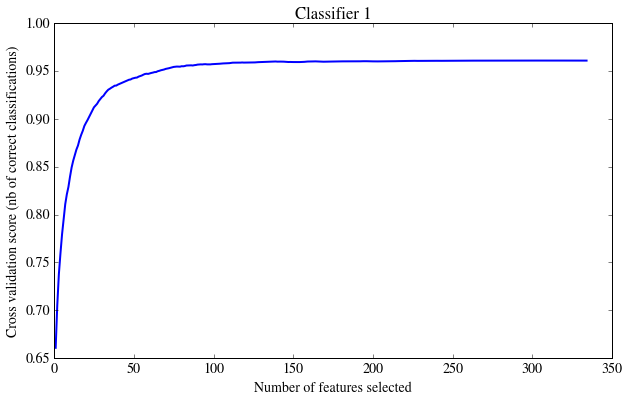

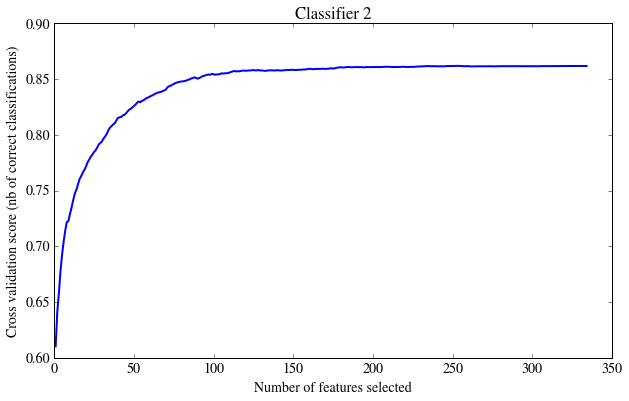

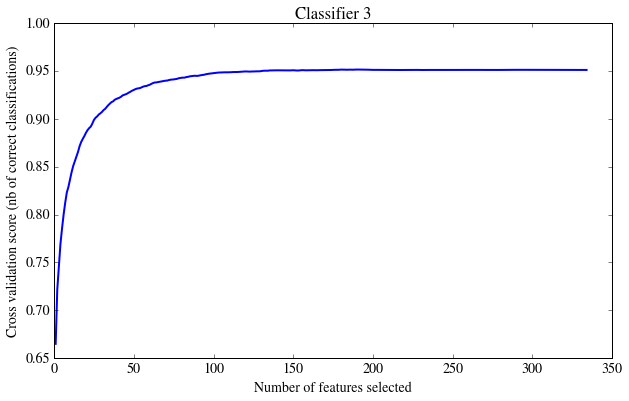

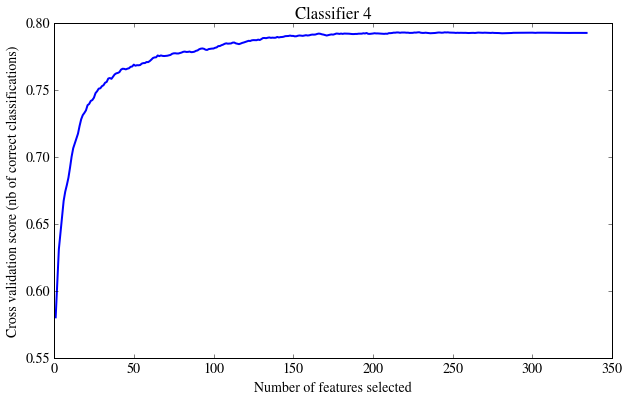

In [40]:
# Plotting code taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
%run 'plot_learning_curve.py'

from sklearn.feature_selection import RFECV

def plotFeatureRankings(classifier, grid_scores):
    """ Plot number of features VS. cross-validation scores
    """
    plt.figure()
    plt.title('Classifier {}'.format(classifier))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(grid_scores) + 1), grid_scores)
    plt.show()
        
def createRFEScores(model, modelName, i, X_train, Y_train, X_test, Y_test):
    """
    """

    rfecv = RFECV(model, scoring='roc_auc', verbose=2, n_jobs=-1)
    rfecv.fit(X_train, Y_train)
    rfecv.score(X_test, Y_test)
    print('Model {} Number Features {}'.format(i, rfecv.n_features_))
    print('Model {} Number Estimators {}'.format(i, rfecv.ranking_))
    print('Model {} Scores {}'.format(i, rfecv.grid_scores_))
    print('Model {} Support {}'.format(i, rfecv.support_))

    np.save('{}_class{}_ranking.npy'.format(modelName, i+1), rfecv.ranking_)
    np.save('{}_class{}_scores.npy'.format(modelName, i+1), rfecv.grid_scores_)

        
# Set to True to run the RFE (time consuming)
# Set to false to display pre-calculated results
runRFE = False

if runRFE:
    
    createRFEScores(attrsC1.final_model, 'final', 0, attrsC1.X_train, attrsC1.Y_train, attrsC1.X_test, attrsC1.Y_test)
    createRFEScores(attrsC2.final_model, 'final', 1, attrsC2.X_train, attrsC2.Y_train, attrsC2.X_test, attrsC2.Y_test)
    createRFEScores(attrsC3.final_model, 'final', 2, attrsC3.X_train, attrsC3.Y_train, attrsC3.X_test, attrsC3.Y_test)
    createRFEScores(attrsC4.final_model, 'final', 3, attrsC4.X_train, attrsC4.Y_train, attrsC4.X_test, attrsC4.Y_test)

else:
    for i in range(4):
        classifier = i+1
        ranking = np.load('final_class{}_ranking.npy'.format(classifier))
        grid_scores = np.load('final_class{}_scores.npy'.format(classifier))
        
        plotFeatureRankings(classifier, grid_scores)
        

## ROC Curves

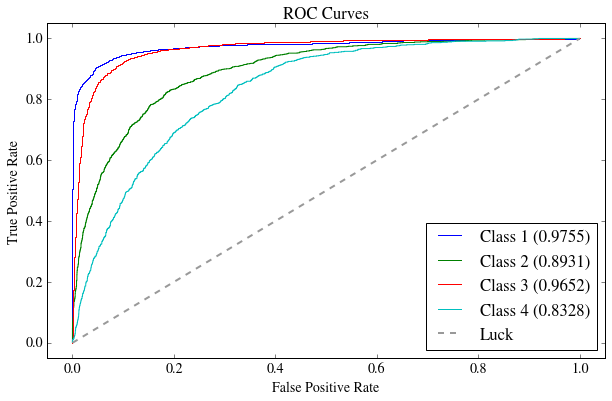

In [70]:
# Compute ROC curve and Area Under the Curve
#fpr[i], tpr[i], _ = roc_curve(attrsC1.Y_test, attrsC1.final_pred)
#fpr, tpr, thresholds = roc_curve(attrsC1.Y_test[0], attrsC1.final_pred[0])
fpr, tpr, thresholds = roc_curve(attrsC1.Y_test, attrsC1.final_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Class 1 ({})'.format(roc_auc.round(4)))

fpr, tpr, thresholds = roc_curve(attrsC2.Y_test, attrsC2.final_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Class 2 ({})'.format(roc_auc.round(4)))

fpr, tpr, thresholds = roc_curve(attrsC3.Y_test, attrsC3.final_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Class 3 ({})'.format(roc_auc.round(4)))

fpr, tpr, thresholds = roc_curve(attrsC4.Y_test, attrsC4.final_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Class 4 ({})'.format(roc_auc.round(4)))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()